<a href="https://colab.research.google.com/github/utkarsh-crypto/Gender_classification_VGG-16/blob/main/Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing Important Modules

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten , Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.python.keras.applications.inception_v3 import InceptionV3


In [ ]:
#Checking whether GPU available
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Extracting zipped dataset
drive_path = "/content/drive/MyDrive/cnn/UTKFace.zip"
local_path = '/content'
!cp '{drive_path}' .
os.chdir(local_path)
!unzip -q 'UTKFace.zip'

In [ ]:
#Give dataset path
train_path = '/content/UTKFace/train'
test_path = '/content/UTKFace/test'

Working with 9205 images
Image examples: 
25_0_0_20170117203843296.jpg.chip.jpg


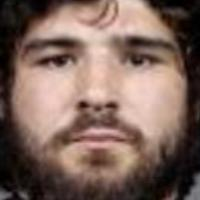

18_0_1_20170117140107728.jpg.chip.jpg


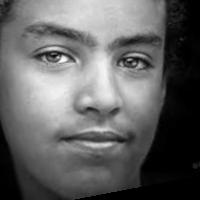

90_0_1_20170113184758168.jpg.chip.jpg


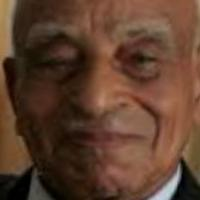

43_0_0_20170104210240958.jpg.chip.jpg


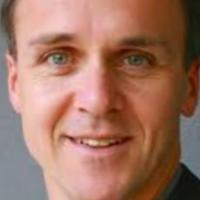

78_0_1_20170117193425610.jpg.chip.jpg


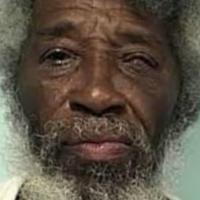

73_0_3_20170119212043986.jpg.chip.jpg


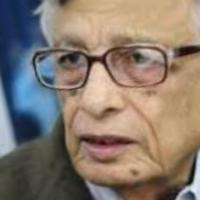

34_0_0_20170117182718307.jpg.chip.jpg


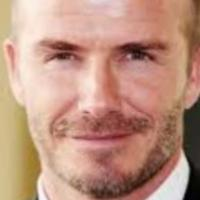

26_0_1_20170116235022816.jpg.chip.jpg


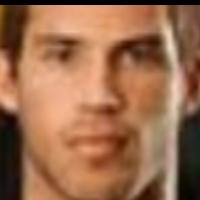

32_0_0_20170117134727342.jpg.chip.jpg


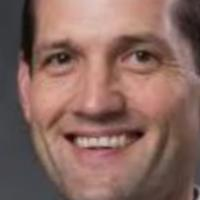

45_0_3_20170119204725919.jpg.chip.jpg


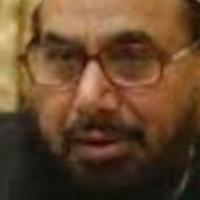

In [ ]:
#Have a look at how the dataset looks
from PIL import Image 
import os 
from IPython.display import display
from IPython.display import Image as _Imgdis
# creating a object  

  
folder = train_path+'/male'


onlymalefiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} images".format(len(onlymalefiles)))
print("Image examples: ")


for i in range(10):
    print(onlymalefiles[i])
    display(_Imgdis(filename=folder + "/" + onlymalefiles[i], width=299, height=299))

In [ ]:
#Pre-Processing
data_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)


train_generator = data_generator.flow_from_directory(
        '/content/UTKFace/train',
        target_size=(299, 299),
        batch_size=12,
        class_mode='categorical')


validation_generator = data_generator.flow_from_directory(
        '/content/UTKFace/val',
        target_size=(299, 299),
        batch_size=12,
        class_mode='categorical')

Found 17287 images belonging to 2 classes.
Found 4616 images belonging to 2 classes.


In [ ]:
num_classes=2

In [ ]:
from keras import models
from keras import layers
incept = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    pooling=None,
)




for layer in incept.layers:
 layer.trainable = False

#Add a layer where input is the output of the  second last layer 
x = Dense(2, activation='softmax', name='predictions')(incept.layers[-2].output)

#Then create the corresponding model 
my_model = Model(inputs = incept.input,outputs = x)
my_model.summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
#from keras.optimizers import Adam

my_model.compile(optimizer = 'RMSprop',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# use early stopping to optimally terminate training through callbacks
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=3)

# save best model automatically
import h5py
mc= ModelCheckpoint('/content/optimal.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)
cb_list=[es,mc]

In [ ]:
model_history=my_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks = cb_list)

Epoch 1/10
1441/1441 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8511
Epoch 00001: val_accuracy improved from -inf to 0.83492, saving model to /content/optimal.h5
1441/1441 [==============================] - 270s 177ms/step - loss: 0.3409 - accuracy: 0.8511 - val_loss: 0.3553 - val_accuracy: 0.8349
Epoch 2/10
1441/1441 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.8710
Epoch 00002: val_accuracy improved from 0.83492 to 0.84315, saving model to /content/optimal.h5
1441/1441 [==============================] - 251s 174ms/step - loss: 0.3049 - accuracy: 0.8710 - val_loss: 0.3432 - val_accuracy: 0.8432
Epoch 3/10
1441/1441 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.8786
Epoch 00003: val_accuracy improved from 0.84315 to 0.84944, saving model to /content/optimal.h5
1441/1441 [==============================] - 251s 174ms/step - loss: 0.2925 - accuracy: 0.8786 - val_loss: 0.3372 - val_accuracy: 0.8494
Epoch 4/10

In [ ]:
#load best model
from keras.models import load_model
saved_model = load_model('/content/optimal.h5')

In [ ]:
#testing on tuned model
test_generator = data_generator.flow_from_directory(
        '/content/UTKFace/test',
        target_size=(299, 299),
        class_mode='categorical')

Found 1804 images belonging to 2 classes.


In [ ]:
results = saved_model.evaluate(test_generator)
results

57/57 [==============================] - 21s 278ms/step - loss: 0.4027 - accuracy: 0.8298


[0.40266528725624084, 0.8298225998878479]

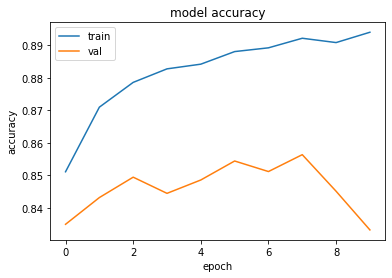

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

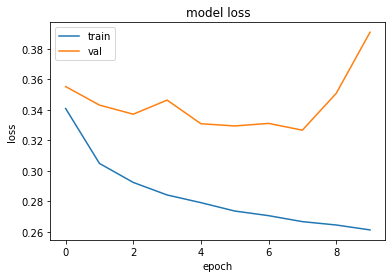

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()